# Weekly Project - Cats & Dogs Classification

![](https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg)

Welcome to the weekly project! Now it's the time to build your first ML application.

The idea is simple: "Cats vs Dogs" classification. Let's build a Flask app to help user upload their image and get the result that is a cat or dog photo.

You will see that not every time your model predicts correctly. Giving users a way to correct the answer if it's wrong or confirm if it's right will be very helpful to improve your model (make it smarter). 

Good luck, and have fun!


LINK TO DATASET: https://www.kaggle.com/tongpython/cat-and-dog


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json

file_name = "/content/drive/MyDrive/kaggle.json"
with open(file_name, 'r') as f:
    document =  json.loads(f.read())
    
print(document)
#{'key': 'c00046e4b093c67705ca6d402f00aa31', 'username': 'nguynnguynkhoa'}

os.environ['KAGGLE_USERNAME'] = document['username']
os.environ['KAGGLE_KEY'] = document['key']

#get API

!kaggle datasets download -d tongpython/cat-and-dog

{'username': 'nguynnguynkhoa', 'key': '86d54991913d6b87880d297405c8173e'}
 98% 213M/218M [00:04<00:00, 56.6MB/s]
100% 218M/218M [00:04<00:00, 53.9MB/s]


In [3]:
!unzip "/content/cat-and-dog.zip"

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [4]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pathlib
import IPython.display as display
import cv2
import time
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Activation
import random

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
tf.__version__

'2.6.0'

In [7]:
# check Pillow version number
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.1.2


In [8]:
Learningrate = 0.001
TRAIN_DIR_DOG = '/content/training_set/training_set/dogs'
TRAIN_DIR_CAT = '/content/training_set/training_set/cats'
MODEL_NAME = 'Catanddog_Detect'
Img_size = 224

In [9]:
from os import listdir
from os.path import isfile, join

In [10]:
dog = os.listdir(TRAIN_DIR_DOG)
dog_paths = [os.path.join(TRAIN_DIR_DOG, f) for f in dog]
cat = os.listdir(TRAIN_DIR_CAT)
cat_paths = [os.path.join(TRAIN_DIR_CAT, f) for f in cat]

In [11]:
dog_count = len(dog_paths)
cat_count = len(cat_paths)
print(dog_count)
print(cat_count)

4006
4001


In [12]:
for i in dog_paths:
  if i[-5] == ")":
    dog_paths.remove(i)
  if i[-3:] != "jpg":
    dog_paths.remove(i)

In [13]:
for i in cat_paths:
  if i[-5] == ")":
    cat_paths.remove(i)
  if i[-3:] != "jpg":
    cat_paths.remove(i)

In [14]:
image_paths = dog_paths + cat_paths

In [15]:
print(len(image_paths))

8000


In [16]:
import random
all_paths = random.sample(image_paths,len(image_paths))

In [17]:
all_paths = all_paths[:25000]

In [18]:
print(all_paths[:4])

['/content/training_set/training_set/dogs/dog.2020.jpg', '/content/training_set/training_set/dogs/dog.454.jpg', '/content/training_set/training_set/dogs/dog.260.jpg', '/content/training_set/training_set/dogs/dog.1488.jpg']


In [19]:
# Preprocess an image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [Img_size, Img_size])
    image /= 255.0
    return image

# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [20]:
# get labels
all_image_labels = [p.split(os.path.sep)[-1][0:3] for p in all_paths]

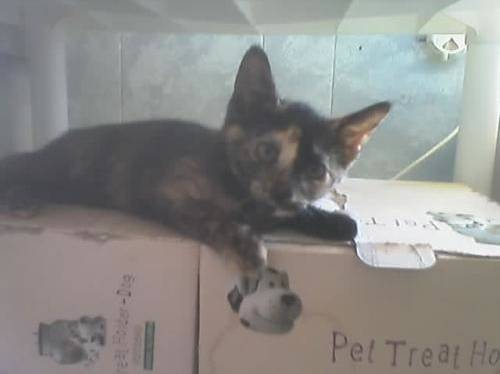

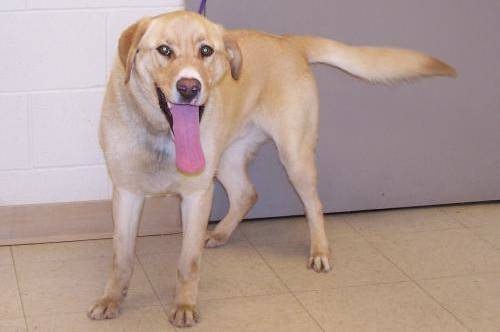

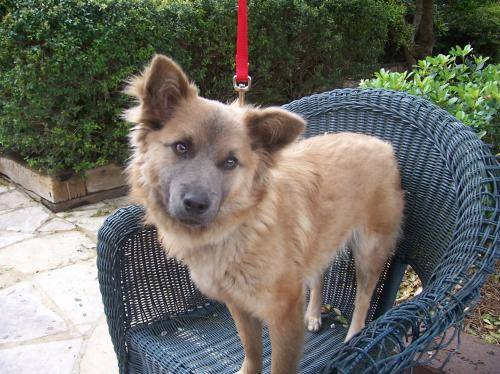

In [21]:
import IPython.display as display

for n in range(3):
    image_path = random.choice(image_paths)
    display.display(display.Image(image_path))
    print()

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
# transfer name to number
le = LabelEncoder()
labels = le.fit_transform(all_image_labels)

In [24]:
label_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int64))

In [25]:
label_dataset

<TensorSliceDataset shapes: (), types: tf.int64>

In [26]:
print("First 10 labels indices: ", labels[:10])

First 10 labels indices:  [1 1 1 1 0 1 0 0 0 0]


In [27]:
# Create dataset from image paths
path_dataset = tf.data.Dataset.from_tensor_slices(all_paths)


In [28]:
# Create image dataset from path dataset
image_dataset = path_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [29]:
path_dataset

<TensorSliceDataset shapes: (), types: tf.string>

In [30]:
# Combine image dataset and image label dataset
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

In [31]:
# Split train, test and validation set
DATASET_SIZE = 25000
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 4096

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

dataset = dataset.shuffle(buffer_size = SHUFFLE_BUFFER_SIZE)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [32]:
# Perform mini-batch in train_dataset and test_dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [33]:
# Define model
def define_model():
    # load model
    model = tf.keras.applications.Xception(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = tf.keras.Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = tf.keras.optimizers.RMSprop(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = define_model()

83697664/83683744 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [34]:
# Train model
model_history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset)

Epoch 1/10
62/62 [==============================] - 117s 1s/step - loss: 4.1942 - accuracy: 0.9670
Epoch 2/10
62/62 [==============================] - 80s 1s/step - loss: 0.8056 - accuracy: 0.9898
Epoch 3/10
62/62 [==============================] - 79s 1s/step - loss: 0.3613 - accuracy: 0.9921
Epoch 4/10
62/62 [==============================] - 80s 1s/step - loss: 0.0775 - accuracy: 0.9962
Epoch 5/10
62/62 [==============================] - 79s 1s/step - loss: 0.0739 - accuracy: 0.9972
Epoch 6/10
62/62 [==============================] - 79s 1s/step - loss: 0.1585 - accuracy: 0.9953
Epoch 7/10
62/62 [==============================] - 79s 1s/step - loss: 0.0837 - accuracy: 0.9968
Epoch 8/10
62/62 [==============================] - 79s 1s/step - loss: 0.0976 - accuracy: 0.9965
Epoch 9/10
62/62 [==============================] - 79s 1s/step - loss: 0.1771 - accuracy: 0.9962
Epoch 10/10
62/62 [==============================] - 79s 1s/step - loss: 0.0353 - accuracy: 0.9982


In [36]:
# Save model
model.save('Catanddog_Detect.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
